# 1. Check the Volatility and MA relationship

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset with the data you want to compute the volatility and MA for
file_path = "SPX and SPXL.xlsx"

# Load the "Combined" sheet
df = pd.read_excel(file_path, sheet_name="Combined")

# Ensure the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

Correlation coefficient: 0.9950166528789334


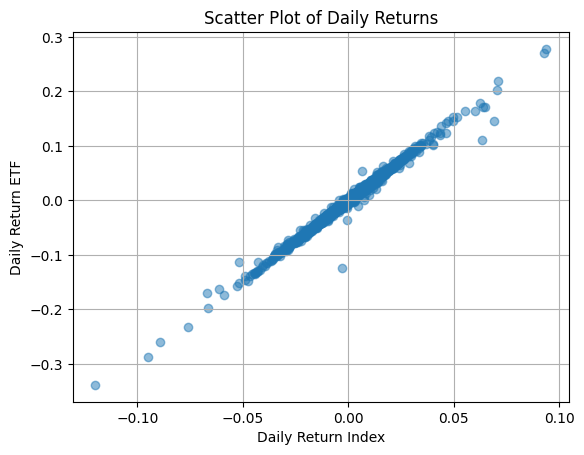

In [3]:
# Calculate returns for Index and ETF
df['returnsIndex'] = df['SPX Price'].pct_change()
df['returnsETF'] = df['SPXL ETF Price'].pct_change()

correlation = df['returnsIndex'].corr(df['returnsETF'])
print("Correlation coefficient:", correlation)

# Optionally, create a scatter plot to visualize the relationship
plt.scatter(df['returnsIndex'], df['returnsETF'], alpha=0.5)
plt.xlabel('Daily Return Index')
plt.ylabel('Daily Return ETF')
plt.title('Scatter Plot of Daily Returns')
plt.grid(True)
plt.show()

Average Volatility for periods above and below the Moving Average:
   MA_Window  Avg_Volatility_Above  Avg_Volatility_Below
0         10              0.022913              0.033499
1         20              0.024156              0.036383
2         50              0.022452              0.034716
3        100              0.026111              0.039404
4        200              0.025010              0.045482


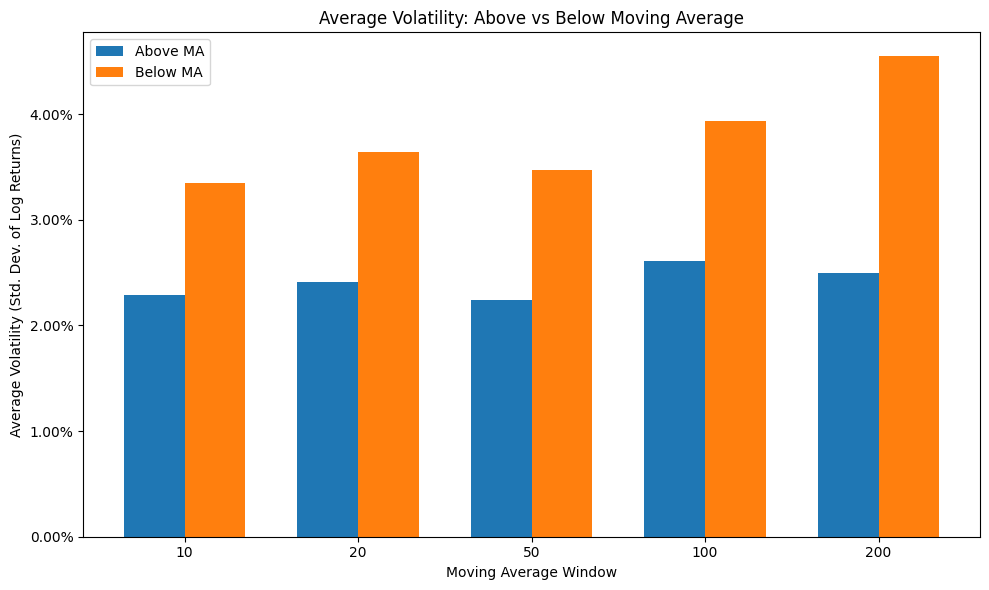

In [4]:
import matplotlib.ticker as mtick

# Calculate log returns (volatility proxy)
df['log_return'] = np.log(df['SPXL ETF Price']).diff()

# Define the moving average windows
ma_windows = [10, 20, 50, 100, 200]

# Initialize a list to store results
results = []

# Loop through each moving average window (RMB to change the Price column name with different datasets)
for ma in ma_windows:
    ma_col = f'MA_{ma}'
    signal_col = f'signal_{ma}'
    group_col = f'group_{ma}'
    
    # Compute the moving average
    df[ma_col] = df['SPXL ETF Price'].rolling(window=ma).mean()
    
    # Create a signal: 1 if Price > MA, 0 otherwise
    df[signal_col] = np.where(df['SPXL ETF Price'] > df[ma_col], 1, 0)
    
    # Identify contiguous segments where the signal is constant.
    # Each time the signal changes, we increment the group number.
    df[group_col] = (df[signal_col] != df[signal_col].shift(1)).cumsum()
    
    # Group by the contiguous segments (ignoring the first row with NaN returns)
    groups = df.dropna(subset=['log_return']).groupby(group_col)
    
    # For each group, calculate the volatility (standard deviation of log returns)
    # and note whether the segment was above (1) or below (0) the MA.
    group_stats = groups.agg({'log_return': 'std', signal_col: 'first'})
    group_stats.rename(columns={'log_return': 'volatility', signal_col: 'signal'}, inplace=True)
    
    # Calculate average volatility for periods where the price is above and below the MA
    avg_vol_above = group_stats[group_stats['signal'] == 1]['volatility'].mean()
    avg_vol_below = group_stats[group_stats['signal'] == 0]['volatility'].mean()
    
    results.append({
        'MA_Window': ma, 
        'Avg_Volatility_Above': avg_vol_above, 
        'Avg_Volatility_Below': avg_vol_below
    })

# Create a table (DataFrame) from the results
result_df = pd.DataFrame(results)
print("Average Volatility for periods above and below the Moving Average:")
print(result_df)

# Plotting the results: grouped bar chart comparing above vs below MA volatility for each MA window.
x = np.arange(len(ma_windows))  # positions for each MA window
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars_above = ax.bar(x - width/2, result_df['Avg_Volatility_Above'], width, label='Above MA')
bars_below = ax.bar(x + width/2, result_df['Avg_Volatility_Below'], width, label='Below MA')

ax.set_xlabel('Moving Average Window')
ax.set_ylabel('Average Volatility (Std. Dev. of Log Returns)')
ax.set_title('Average Volatility: Above vs Below Moving Average')
ax.set_xticks(x)
ax.set_xticklabels(ma_windows)
ax.legend()

#Percentage format
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

Average Annualized Volatility for periods above and below the Moving Average:
   MA_Window  Avg_Annualized_Vol_Above  Avg_Annualized_Vol_Below
0         10                  0.363725                  0.531777
1         20                  0.383464                  0.577567
2         50                  0.356420                  0.551102
3        100                  0.414506                  0.625525
4        200                  0.397028                  0.722000


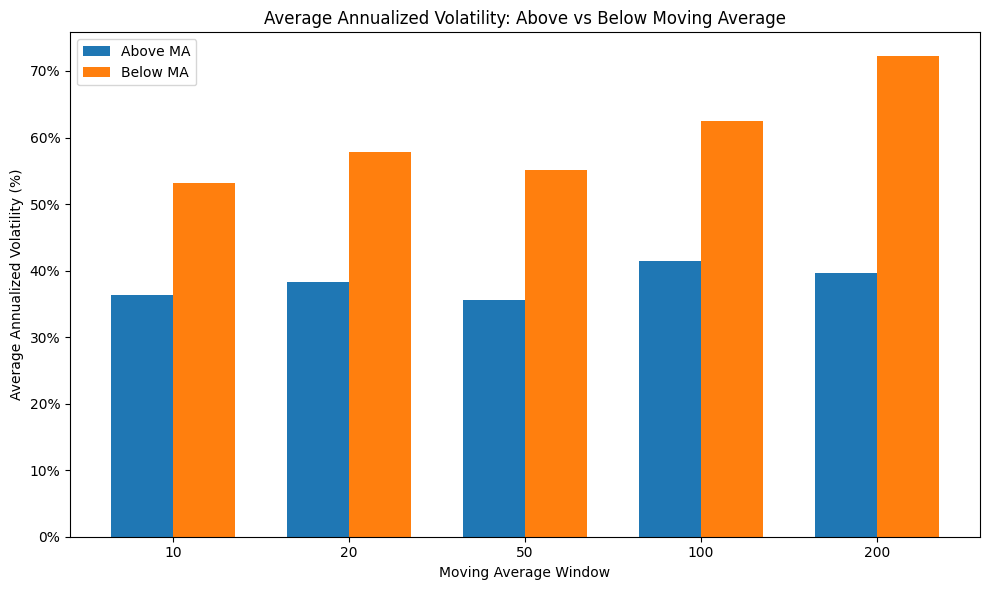

In [5]:
# To see annualized volatility
# Calculate log returns (volatility proxy)
df['log_return'] = np.log(df['SPXL ETF Price']).diff()

# Define the moving average windows
ma_windows = [10, 20, 50, 100, 200]

# Annualization factor (assuming daily returns, 252 trading days in a year)
annualization_factor = np.sqrt(252)

# Initialize a list to store results
results = []

# Loop through each moving average window
for ma in ma_windows:
    ma_col = f'MA_{ma}'
    signal_col = f'signal_{ma}'
    group_col = f'group_{ma}'
    
    # Compute the moving average
    df[ma_col] = df['SPXL ETF Price'].rolling(window=ma).mean()
    
    # Create a signal: 1 if Price > MA, 0 otherwise
    df[signal_col] = np.where(df['SPXL ETF Price'] > df[ma_col], 1, 0)
    
    # Identify contiguous segments where the signal is constant.
    df[group_col] = (df[signal_col] != df[signal_col].shift(1)).cumsum()
    
    # Group by these segments (ignoring the first row with NaN returns)
    groups = df.dropna(subset=['log_return']).groupby(group_col)
    
    # For each group, calculate the volatility (std dev of log returns)
    # and record whether the segment was above (1) or below (0) the MA.
    group_stats = groups.agg({'log_return': 'std', signal_col: 'first'})
    group_stats.rename(columns={'log_return': 'volatility', signal_col: 'signal'}, inplace=True)
    
    # Annualize the volatility by multiplying by sqrt(252)
    group_stats['annualized_vol'] = group_stats['volatility'] * annualization_factor
    
    # Calculate average annualized volatility for periods where the price is above and below the MA
    avg_vol_above = group_stats[group_stats['signal'] == 1]['annualized_vol'].mean()
    avg_vol_below = group_stats[group_stats['signal'] == 0]['annualized_vol'].mean()
    
    results.append({
        'MA_Window': ma, 
        'Avg_Annualized_Vol_Above': avg_vol_above, 
        'Avg_Annualized_Vol_Below': avg_vol_below
    })

# Create a table (DataFrame) from the results
result_df = pd.DataFrame(results)
print("Average Annualized Volatility for periods above and below the Moving Average:")
print(result_df)

# Plotting the results: grouped bar chart comparing above vs below MA annualized volatility for each MA window.
x = np.arange(len(ma_windows))  # positions for each MA window
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars_above = ax.bar(x - width/2, result_df['Avg_Annualized_Vol_Above'], width, label='Above MA')
bars_below = ax.bar(x + width/2, result_df['Avg_Annualized_Vol_Below'], width, label='Below MA')

ax.set_xlabel('Moving Average Window')
ax.set_ylabel('Average Annualized Volatility (%)')
ax.set_title('Average Annualized Volatility: Above vs Below Moving Average')
ax.set_xticks(x)
ax.set_xticklabels(ma_windows)
ax.legend()

# Format the y-axis to display percentages. The PercentFormatter expects values between 0 and 1,
# so if your annualized volatility is e.g., 0.20 for 20%, this will work as expected.
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

# Implementation of strategy

In [7]:
# Revised logic 1.6
# ------------------ PARAMETERS ------------------ #
initial_investment = 1000
transaction_cost = 0.005  # per share
slippage = 0.001          # as a % of price
atr_period = 30
atr_multiplier = 1.5      # multiplier for dynamic trailing stop

# Scaling out parameters
scaling_threshold = 0.05  # profit threshold for partial exit
scaling_ratio = 0.5       # Sell 50% of shares held once threshold is hit

# Walk forward settings
window_test = 252
step = window_test

DEBUG = False  # Toggle debug output

# ------------------ FUNCTIONS ------------------ #

def calculate_atr(df, atr_period):
    df = df.copy()
    df['Previous_Close'] = df['SPXL ETF Price'].shift(1)
    df['TR'] = df.apply(lambda row: max(
        row['SPXL ETF High'] - row['SPXL ETF Low'],
        abs(row['SPXL ETF High'] - row['Previous_Close']) if pd.notnull(row['Previous_Close']) else 0,
        abs(row['SPXL ETF Low'] - row['Previous_Close']) if pd.notnull(row['Previous_Close']) else 0
    ), axis=1)
    df['ATR'] = df['TR'].rolling(window=atr_period, min_periods=1).mean()
    return df

def select_adaptive_parameters(segment, global_median_atr,
                               base_atr_multiplier=atr_multiplier,
                               base_scaling_threshold=scaling_threshold,
                               base_scaling_ratio=scaling_ratio):
    """Return adaptive parameters for ATR multiplier, scaling threshold, and scaling ratio."""
    segment_avg_atr = segment['ATR'].mean()
    if segment_avg_atr > global_median_atr:
        adaptive_atr_multiplier = base_atr_multiplier * 1.2  # 20% increase
        adaptive_scaling_threshold = base_scaling_threshold * 1.2
        adaptive_scaling_ratio = base_scaling_ratio * 1.5
    else:
        adaptive_atr_multiplier = base_atr_multiplier
        adaptive_scaling_threshold = base_scaling_threshold
        adaptive_scaling_ratio = base_scaling_ratio
    if DEBUG:
        print(f"Adaptive parameters: ATR multiplier={adaptive_atr_multiplier}, "
              f"scaling threshold={adaptive_scaling_threshold}, "
              f"scaling ratio={adaptive_scaling_ratio}")
    return adaptive_atr_multiplier, adaptive_scaling_threshold, adaptive_scaling_ratio

def run_segment(segment, starting_value, ma, global_median_atr):
    """
    Run the trading simulation on one segment.
    Returns the updated segment (with Portfolio_Value, Signal, etc.) and the ending portfolio value.
    """
    segment = segment.copy()
    # Initialize portfolio value column
    segment['Portfolio_Value'] = np.nan
    segment.at[segment.index[0], 'Portfolio_Value'] = starting_value

    segment['Signal'] = 0         # 1=Buy, 0=Hold, -1=Sell
    segment['Trade_Price'] = np.nan
    segment['Trailing_Stop'] = np.nan

    # Select adaptive parameters for this segment
    adaptive_atr_multiplier, adaptive_scaling_threshold, adaptive_scaling_ratio = \
        select_adaptive_parameters(segment, global_median_atr)

    # Initialize state variables
    in_trade = False
    pending_buy = False
    pending_buy_idx = None
    pending_exit = False
    pending_exit_idx = None
    trade_price = 0
    shares_held = 0
    trailing_stop = 0
    entry_date = None
    partial_exit_done = False
    cash_on_hand = 0
    hold_period = 3  # days to hold before considering MA exit

    # Loop over each row in the segment
    for i in range(len(segment)):
        current_date = segment['Date'].iloc[i]
        current_open = segment['SPXL ETF Open'].iloc[i]
        current_close = segment['SPXL ETF Price'].iloc[i]
        current_low = segment['SPXL ETF Low'].iloc[i]
        current_high = segment['SPXL ETF High'].iloc[i]
        current_atr = segment['ATR'].iloc[i]

        if DEBUG:
            print(f"\nIndex {i}, Date: {current_date}")
            print(f"Open: {current_open}, Close: {current_close}, Low: {current_low}, High: {current_high}, ATR: {current_atr}")

        # ----- Execute Pending Buy Order -----
        if pending_buy:
            # Use previous portfolio value to determine current notional
            current_notional = segment.at[segment.index[i-1], 'Portfolio_Value'] if i > 0 else starting_value
            trade_price = current_open + transaction_cost + (current_open * slippage)
            shares_held = current_notional / trade_price
            trailing_stop = trade_price - (adaptive_atr_multiplier * current_atr)
            partial_exit_done = False
            cash_on_hand = 0
            entry_date = segment['Date'].iloc[pending_buy_idx]
            segment.at[segment.index[i], 'Signal'] = 1
            segment.at[segment.index[i], 'Trade_Price'] = trade_price
            in_trade = True
            pending_buy = False
            if DEBUG:
                print(f"BUY executed at index {i}: trade_price={trade_price}, shares_held={shares_held}, trailing_stop={trailing_stop}")

        # ----- Execute Pending Exit Order -----
        if pending_exit:
            exit_price = current_close - transaction_cost - (current_close * slippage)
            trade_return = (exit_price - trade_price) / trade_price
            segment.at[segment.index[i], 'Signal'] = -1
            segment.at[segment.index[i], 'Trade_Price'] = exit_price
            segment.at[segment.index[i], 'Trade_Return'] = trade_return
            final_value = cash_on_hand + (shares_held * exit_price)
            segment.at[segment.index[i], 'Portfolio_Value'] = final_value
            if DEBUG:
                print(f"SELL executed at index {i}: exit_price={exit_price}, trade_return={trade_return}, final_value={final_value}")
            shares_held = 0
            cash_on_hand = 0
            in_trade = False
            pending_exit = False

        # ----- Signal Generation -----
        if (not in_trade) and (not pending_buy):
            # Buy signal: SPX Open > MA line
            if segment['SPX Open'].iloc[i] > segment[ma].iloc[i]:
                pending_buy = True
                pending_buy_idx = i
                if DEBUG:
                    print(f"Buy signal generated at index {i} for {ma}")

        # ----- In-Trade Processing -----
        if in_trade:
            # Update dynamic trailing stop
            trailing_stop = max(trailing_stop, current_high - (adaptive_atr_multiplier * current_atr))
            segment.at[segment.index[i], 'Trailing_Stop'] = trailing_stop

            # Partial exit logic: scale out if profit exceeds threshold
            if not partial_exit_done:
                current_gain = (current_close - trade_price) / trade_price
                if current_gain >= adaptive_scaling_threshold:
                    shares_to_sell = adaptive_scaling_ratio * shares_held
                    realized_value = shares_to_sell * current_close
                    cash_on_hand += realized_value
                    shares_held -= shares_to_sell
                    partial_exit_done = True
                    if DEBUG:
                        print(f"Partial exit at index {i}: sold {shares_to_sell} shares, cash_on_hand={cash_on_hand}")

            # Mark-to-market update: recalc portfolio value
            segment.at[segment.index[i], 'Portfolio_Value'] = cash_on_hand + (shares_held * current_close)

            # Exit conditions: stop loss or MA exit after hold period
            if current_low < trailing_stop and not pending_exit:
                pending_exit = True
                pending_exit_idx = i
                if DEBUG:
                    print(f"Stop loss triggered at index {i}")
            elif (entry_date is not None and 
                  (segment['Date'].iloc[i] - entry_date).days >= hold_period and 
                  current_close < segment[ma].iloc[i] * 0.98 and not pending_exit):
                pending_exit = True
                pending_exit_idx = i
                if DEBUG:
                    print(f"MA exit triggered at index {i}")
        else:
            # Not in trade: carry forward previous portfolio value
            segment.at[segment.index[i], 'Portfolio_Value'] = segment.at[segment.index[i-1], 'Portfolio_Value'] if i > 0 else starting_value

    ending_value = segment['Portfolio_Value'].iloc[-1]
    return segment, ending_value

def walk_forward_backtest(df, ma_list):
    """
    Performs walk-forward backtesting for each moving-average (MA).
    Returns a dictionary with keys as MA names and values as the combined simulation results.
    """
    df = df.copy()
    df.sort_values(by='Date', inplace=True)
    df = calculate_atr(df, atr_period)
    global_median_atr = df['ATR'].median()

    results = {}
    for ma in ma_list:
        overall_results_list = []
        current_portfolio_value = initial_investment

        # Loop over segments defined by window_test/step
        for start in range(0, len(df), step):
            end = start + window_test
            segment = df.iloc[start:end].copy()
            if len(segment) == 0:
                break

            seg_result, ending_value = run_segment(segment, current_portfolio_value, ma, global_median_atr)
            current_portfolio_value = ending_value  # Propagate portfolio value to next segment
            overall_results_list.append(seg_result)

        overall_results = pd.concat(overall_results_list)
        results[ma] = overall_results

    return results

# ------------------ EXECUTION ------------------ #

# Assuming 'df' is already defined with columns: Date, SPXL ETF Price, SPXL ETF Open, SPXL ETF High, SPXL ETF Low, SPX Open,
# and moving average columns like MA_10, MA_20, etc.
ma_list = ['MA_10', 'MA_20', 'MA_50', 'MA_100', 'MA_200']
results = walk_forward_backtest(df, ma_list)
print("Walk-forward backtest completed successfully")

# Example: Print out Date and Portfolio_Value for the MA_10 strategy
print(results['MA_10'][['Date', 'Portfolio_Value']])


Walk-forward backtest completed successfully
           Date  Portfolio_Value
0    2008-11-06      1000.000000
1    2008-11-07      1000.000000
2    2008-11-10      1000.000000
3    2008-11-11      1000.000000
4    2008-11-12      1000.000000
...         ...              ...
4097 2025-02-21      7774.738382
4098 2025-02-24      7774.738382
4099 2025-02-25      7650.320967
4100 2025-02-26      7656.120044
4101 2025-02-27      7295.685097

[4102 rows x 2 columns]


Excel file 'SPXLV3_WithCosts_Compound_scalingOut_Adaptive_100325.xlsx' has been created with a separate sheet for each strategy.


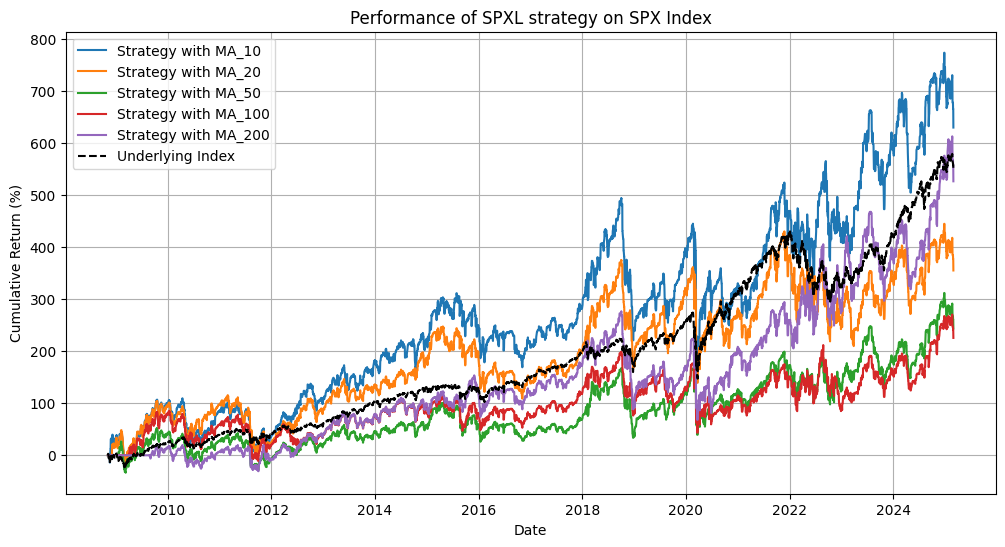

In [8]:
# Calculate cumulative returns for each strategy (if not already calculated)
for ma, df_copy in results.items():
    # Calculate daily returns from portfolio value
    df_copy['Daily_Return'] = df_copy['Portfolio_Value'].pct_change().fillna(0)
    # Calculate cumulative returns: cumulative product of (1 + daily return) minus 1
    df_copy['Cumulative_Return'] = (1 + df_copy['Daily_Return']).cumprod() - 1

# Write each MA's signals and performance to a separate sheet in the Excel file
excel_filename = "SPXLV3_WithCosts_Compound_scalingOut_Adaptive_100325.xlsx"
with pd.ExcelWriter(excel_filename) as writer:
    for ma, df_copy in results.items():
        # Select columns to output - adjust as needed
        sheet_df = df_copy[['Date', 'Signal', 'Trade_Price', 'Portfolio_Value', 'Daily_Return', 'Cumulative_Return']].copy()
       #sheet_df = sheet_df[sheet_df['Signal'] != 0] # remove if you want to see the whole time series
        #Use the moving average as the sheet name (or prefix it if you prefer)
        sheet_name = f"{ma}"
        sheet_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Excel file '{excel_filename}' has been created with a separate sheet for each strategy.")

#Calculating underlying index returns 
df['Index_return'] = df['SPX Price'].pct_change().fillna(0)
df['Index_cum_ret'] = (1 + df['Index_return']).cumprod() - 1

# Plot Cumulative Returns for Each MA Strategy
plt.figure(figsize=(12, 6))
for ma, df_copy in results.items():
    plt.plot(df_copy['Date'], df_copy['Cumulative_Return'] * 100, label=f"Strategy with {ma}")  # multiplied by 100 for percentage display

plt.plot(df['Date'], df['Index_cum_ret'] * 100, label="Underlying Index", color='black', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Performance of SPXL strategy on SPX Index")
plt.legend()
plt.grid()
plt.show()

### Monte Carlo Simulation

Results saved to SPXL_monte_carlo_MA200_100325.xlsx


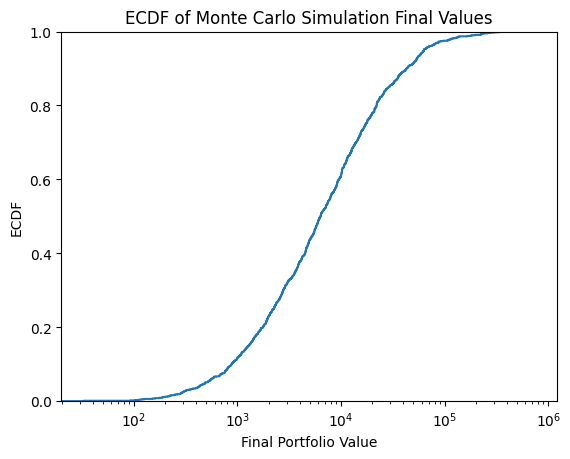

In [10]:
import seaborn as sns

# Run a monte
# Select one of the strategy results
simulated_df = results['MA_200']

# Extract daily returns from your simulation
daily_returns = simulated_df['Daily_Return'].values
n_days = len(daily_returns)

# Number of Monte Carlo iterations
n_simulations = 1000

# Store the final portfolio value for each simulation
final_values = []

for sim in range(n_simulations):
    # Resample daily returns with replacement to simulate a possible path
    sim_returns = np.random.choice(daily_returns, size=n_days, replace=True)
    # Compute the cumulative portfolio value over time
    portfolio_path = initial_investment * np.cumprod(1 + sim_returns)
    final_values.append(portfolio_path[-1])

monte_carlo_df = pd.DataFrame(final_values, columns=['Final Portfolio Value'])

# Save the strategy simulation and Monte Carlo results to an Excel file
excel_filename = "SPXL_monte_carlo_MA200_100325.xlsx"
with pd.ExcelWriter(excel_filename) as writer:
    simulated_df.to_excel(writer, sheet_name="Strategy Simulation", index=False)
    monte_carlo_df.to_excel(writer, sheet_name="Monte Carlo Final Values", index=False)

print(f"Results saved to {excel_filename}")


sns.ecdfplot(data=final_values)
plt.xscale("log")  # optional, if you want to handle large outliers
plt.xlabel("Final Portfolio Value")
plt.ylabel("ECDF")
plt.title("ECDF of Monte Carlo Simulation Final Values")
plt.show()

# Plot the distribution of final portfolio values
# plt.figure(figsize=(10, 6))
# plt.hist(final_values, bins=50, edgecolor='k', alpha=0.75, log= True)
# plt.title("Monte Carlo Simulation of Final Portfolio Value (MA_)")
# plt.xlabel("Final Portfolio Value")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()

## GRAVEYARD

In [ ]:
# Revised logic 1.5 rolling windows
# ------------------ PARAMETERS ------------------ #
initial_investment = 1000
transaction_cost = 0.005  # e.g., 0.001 for 0.1% per share
slippage = 0.001          # 0.1%
atr_period = 30           # ATR lookback period
atr_multiplier = 1.5      # Multiplier for dynamic trailing stop

# Scaling out parameters
scaling_threshold = 0.05  # 5% profit threshold for partial exit
scaling_ratio = 0.5       # Sell 50% of shares when threshold is hit

DEBUG = False  # Toggle debug output

# ------------------ WALK-FORWARD SETTINGS ------------------ #
# For example, use a test window of 252 trading days (about 1 year)
window_test = 252  
step = window_test  # Roll forward by the full test window

results = {}

# For each moving average we want to test:
for ma in ['MA_10', 'MA_20', 'MA_50', 'MA_100', 'MA_200']:
    # Make a copy and sort by date
    df_copy = df.copy()
    df_copy.sort_values(by='Date', inplace=True)
    
    # Pre-calculate ATR on the entire dataset
    df_copy['Previous_Close'] = df_copy['SPXL ETF Price'].shift(1)
    df_copy['TR'] = df_copy.apply(lambda row: max(
        row['SPXL ETF High'] - row['SPXL ETF Low'],
        abs(row['SPXL ETF High'] - row['Previous_Close']) if pd.notna(row['Previous_Close']) else 0,
        abs(row['SPXL ETF Low'] - row['Previous_Close']) if pd.notna(row['Previous_Close']) else 0
    ), axis=1)
    df_copy['ATR'] = df_copy['TR'].rolling(window=atr_period, min_periods=1).mean()
    
    # We'll accumulate the walk‑forward results here.
    overall_results_list = []
    current_portfolio_value = initial_investment
    
    # Walk-forward loop: step through the data in blocks of window_test days.
    for start in range(0, len(df_copy), step):
        end = start + window_test
        segment = df_copy.iloc[start:end].copy()
        if len(segment) == 0:
            break

        # Set the starting portfolio value for this segment.
        segment.at[segment.index[0], 'Portfolio_Value'] = current_portfolio_value
        
        # Initialize additional columns for the simulation.
        segment['Signal'] = 0           # 1 = Buy, -1 = Sell, 0 = Hold
        segment['Position'] = 0         # Not used explicitly here, but can be added if needed.
        segment['Trade_Price'] = np.nan # Entry/Exit Price
        segment['Trailing_Stop'] = np.nan
        
        # ------------------ Strategy State Variables ------------------ #
        in_trade = False
        pending_buy = False
        pending_buy_idx = None
        pending_exit = False
        pending_exit_idx = None
        
        # Trade-specific variables
        trade_price = 0
        shares_held = 0
        trailing_stop = 0
        entry_date = None
        
        # Partial exit tracking
        partial_exit_done = False  # Only one partial exit in this example
        cash_on_hand = 0           # Cash realized from partial exit(s)
        
        # Hold period (in days)
        hold_period = 3
        
        # ------------------ Simulation Loop for This Segment ------------------ #
        for i in range(len(segment)):
            current_date = segment['Date'].iloc[i]
            current_open = segment['SPXL ETF Open'].iloc[i]
            current_close = segment['SPXL ETF Price'].iloc[i]
            current_low = segment['SPXL ETF Low'].iloc[i]
            current_high = segment['SPXL ETF High'].iloc[i]
            current_atr = segment['ATR'].iloc[i]
            
            if DEBUG:
                print("\n---")
                print(f"Index: {i}, Date: {current_date}")
                print(f"Open: {current_open}, Close: {current_close}, Low: {current_low}, High: {current_high}")
                print(f"ATR: {current_atr}")
            
            # ----- Execute Pending Buy Order -----
            if pending_buy:
                if DEBUG:
                    print(f"Executing pending BUY order (signal from index {pending_buy_idx} on {segment['Date'].iloc[pending_buy_idx]})")
                current_notional = segment.at[segment.index[i-1], 'Portfolio_Value'] if i > 0 else current_portfolio_value
                trade_price = current_open + transaction_cost + (current_open * slippage)
                shares_held = current_notional / trade_price
                trailing_stop = trade_price - (atr_multiplier * current_atr)
                partial_exit_done = False
                cash_on_hand = 0
                entry_date = segment['Date'].iloc[pending_buy_idx]
                segment.at[segment.index[i], 'Signal'] = 1
                segment.at[segment.index[i], 'Trade_Price'] = trade_price
                in_trade = True
                pending_buy = False
                if DEBUG:
                    print(f"BUY EXECUTED: Trade Price = {trade_price}, Shares Held = {shares_held}, Trailing Stop = {trailing_stop}")
            
            # ----- Execute Pending Exit Order -----
            if pending_exit:
                if DEBUG:
                    print(f"Executing pending EXIT order (signal from index {pending_exit_idx} on {segment['Date'].iloc[pending_exit_idx]})")
                exit_price = current_close - transaction_cost - (current_close * slippage)
                trade_return = (exit_price - trade_price) / trade_price
                segment.at[segment.index[i], 'Signal'] = -1
                segment.at[segment.index[i], 'Trade_Price'] = exit_price
                segment.at[segment.index[i], 'Trade_Return'] = trade_return
                final_value = cash_on_hand + (shares_held * exit_price)
                segment.at[segment.index[i], 'Portfolio_Value'] = final_value
                if DEBUG:
                    print(f"SELL EXECUTED: Exit Price = {exit_price}, Trade Return = {trade_return}, Final Value = {final_value}")
                shares_held = 0
                cash_on_hand = 0
                in_trade = False
                pending_exit = False
            
            # ----- Signal Generation -----
            # For example, using SPX Open compared to the MA value.
            if (not in_trade) and (not pending_buy):
                if segment['SPX Open'].iloc[i] > segment[ma].iloc[i]:
                    pending_buy = True
                    pending_buy_idx = i
                    if DEBUG:
                        print(f"BUY SIGNAL GENERATED at {current_date} for {ma}")
            
            # ----- In-Trade Processing -----
            if in_trade:
                # 1) Update dynamic trailing stop
                previous_trailing_stop = trailing_stop
                new_trailing_stop = current_high - (atr_multiplier * current_atr)
                trailing_stop = max(trailing_stop, new_trailing_stop)
                segment.at[segment.index[i], 'Trailing_Stop'] = trailing_stop
                
                # 2) Partial Exit Logic (scaling out)
                if not partial_exit_done:
                    current_gain = (current_close - trade_price) / trade_price
                    if current_gain >= scaling_threshold:
                        shares_to_sell = scaling_ratio * shares_held
                        realized_value = shares_to_sell * current_close
                        cash_on_hand += realized_value
                        shares_held -= shares_to_sell
                        partial_exit_done = True
                        if DEBUG:
                            print(f"Partial exit triggered at gain={current_gain*100:.2f}%. Sold {shares_to_sell} shares. Cash now={cash_on_hand}.")
                
                # 3) Mark-to-market: update portfolio value each day
                segment.at[segment.index[i], 'Portfolio_Value'] = cash_on_hand + (shares_held * current_close)
                
                # 4) Exit Condition 1: Stop-loss
                if current_low < trailing_stop and not pending_exit:
                    pending_exit = True
                    pending_exit_idx = i
                    if DEBUG:
                        print(f"STOP-LOSS condition met on {current_date}")
                # 5) Exit Condition 2: MA exit after hold period
                elif (entry_date is not None and 
                      (segment['Date'].iloc[i] - entry_date).days >= hold_period and 
                      current_close < segment[ma].iloc[i] * 0.98 and not pending_exit):
                    pending_exit = True
                    pending_exit_idx = i
                    if DEBUG:
                        print(f"MA SELL condition met on {current_date}")
            else:
                # When not in a trade, carry forward previous portfolio value
                segment.at[segment.index[i], 'Portfolio_Value'] = segment.at[segment.index[i-1], 'Portfolio_Value'] if i > 0 else current_portfolio_value
        
            if DEBUG:
                print(f"End of Index {i} Summary:")
                print(f"  In Trade: {in_trade}, Pending Buy: {pending_buy}, Pending Exit: {pending_exit}")
                print(f"  Shares Held: {shares_held}, Cash on Hand: {cash_on_hand}")
                print(f"  Trailing Stop: {trailing_stop}")
                print(f"  Portfolio Value: {segment.at[segment.index[i], 'Portfolio_Value']}")
                print("---")
        
        # End of segment simulation.
        # Update the current portfolio value for the next segment:
        current_portfolio_value = segment['Portfolio_Value'].iloc[-1]
        overall_results_list.append(segment)
    
    # After processing all walk-forward segments for this MA, store the combined results.
    overall_results = pd.concat(overall_results_list)
    results[ma] = overall_results

# (Optional) You can now save the walk-forward results or analyze them.


In [ ]:
# Revised logic 1.4, scaling out of positions and mark to market portfolio value.
#Parameters
initial_investment = 1000
transaction_cost = 0.005  # e.g., 0.001 for 0.1% per share
slippage = 0.001          # 0.1%
atr_period = 30           # ATR lookback period
atr_multiplier = 1.5      # Multiplier for dynamic trailing stop

# Scaling out parameters
scaling_threshold = 0.05  # 5% profit threshold for partial exit
scaling_ratio = 0.5       # Sell 50% of shares when threshold is hit

DEBUG = False  # Toggle debug output

results = {}

# Example MAs to iterate over
for ma in ['MA_10','MA_20','MA_50','MA_100','MA_200']:
    df_copy = df.copy()
    df_copy.sort_values(by='Date', inplace=True)  # Ensure data is sorted chronologically

    # 1. Calculate ATR for dynamic trailing stops
    df_copy['Previous_Close'] = df_copy['SPXL ETF Price'].shift(1)
    df_copy['TR'] = df_copy.apply(lambda row: max(
        row['SPXL ETF High'] - row['SPXL ETF Low'],
        abs(row['SPXL ETF High'] - row['Previous_Close']) if pd.notna(row['Previous_Close']) else 0,
        abs(row['SPXL ETF Low'] - row['Previous_Close']) if pd.notna(row['Previous_Close']) else 0
    ), axis=1)
    df_copy['ATR'] = df_copy['TR'].rolling(window=atr_period, min_periods=1).mean()

    # 2. Initialize columns
    df_copy['Signal'] = 0           # 1 = Buy, -1 = Sell, 0 = Hold
    df_copy['Position'] = 0         # 1 = In Trade, 0 = Out of Trade
    df_copy['Trade_Price'] = np.nan # Entry/Exit Price
    df_copy['Trailing_Stop'] = np.nan
    df_copy['Portfolio_Value'] = initial_investment

    # 3. Strategy State Variables
    in_trade = False
    pending_buy = False
    pending_buy_idx = None
    pending_exit = False
    pending_exit_idx = None

    # Trade-specific variables
    trade_price = 0
    shares_held = 0
    trailing_stop = 0
    entry_date = None

    # Partial exit tracking
    partial_exit_done = False  # Only do one partial exit in this example
    cash_on_hand = 0           # Cash realized from partial exit(s)

    # Hold period (in days)
    hold_period = 3

    # 4. Main Loop
    for i in range(len(df_copy)):
        current_date = df_copy['Date'].iloc[i]
        current_open = df_copy['SPXL ETF Open'].iloc[i]
        current_close = df_copy['SPXL ETF Price'].iloc[i]
        current_low = df_copy['SPXL ETF Low'].iloc[i]
        current_high = df_copy['SPXL ETF High'].iloc[i]
        current_atr = df_copy['ATR'].iloc[i]

        if DEBUG:
            print("\n---")
            print(f"Index: {i}, Date: {current_date}")
            print(f"Open: {current_open}, Close: {current_close}, Low: {current_low}, High: {current_high}")
            print(f"ATR: {current_atr}")

        # ----- Execute Pending Buy Order -----
        if pending_buy:
            if DEBUG:
                print(f"Executing pending BUY order (signal from index {pending_buy_idx} on {df_copy['Date'].iloc[pending_buy_idx]})")
            # Use the current portfolio value as the notional for compounding
            current_notional = df_copy.at[i-1, 'Portfolio_Value'] if i > 0 else initial_investment

            # Buy at today's open (plus costs)
            trade_price = current_open + transaction_cost + (current_open * slippage)
            shares_held = current_notional / trade_price

            # Initialize trailing stop
            trailing_stop = trade_price - (atr_multiplier * current_atr)

            # Reset partial-exit flags and cash
            partial_exit_done = False
            cash_on_hand = 0

            entry_date = df_copy['Date'].iloc[pending_buy_idx]
            df_copy.at[i, 'Signal'] = 1
            df_copy.at[i, 'Trade_Price'] = trade_price
            in_trade = True
            pending_buy = False

            if DEBUG:
                print(f"BUY EXECUTED: Trade Price = {trade_price}, Shares Held = {shares_held}, Trailing Stop = {trailing_stop}")

        # ----- Execute Pending Exit Order -----
        if pending_exit:
            if DEBUG:
                print(f"Executing pending EXIT order (signal from index {pending_exit_idx} on {df_copy['Date'].iloc[pending_exit_idx]})")
            exit_price = current_open - transaction_cost - (current_open * slippage)
            trade_return = (exit_price - trade_price) / trade_price

            df_copy.at[i, 'Signal'] = -1
            df_copy.at[i, 'Trade_Price'] = exit_price
            df_copy.at[i, 'Trade_Return'] = trade_return

            # Final liquidation: combine cash + value of remaining shares
            final_value = cash_on_hand + (shares_held * exit_price)
            df_copy.at[i, 'Portfolio_Value'] = final_value

            if DEBUG:
                print(f"SELL EXECUTED: Exit Price = {exit_price}, Trade Return = {trade_return}, Final Value = {final_value}")

            # Reset trade variables
            shares_held = 0
            cash_on_hand = 0
            in_trade = False
            pending_exit = False

        # ----- Signal Generation -----
        if (not in_trade) and (not pending_buy):
            if df_copy['SPX Open'].iloc[i] > df_copy[ma].iloc[i]:
                # Generate BUY signal
                pending_buy = True
                pending_buy_idx = i
                if DEBUG:
                    print(f"BUY SIGNAL GENERATED at {current_date} for {ma}")

        # ----- In-Trade Processing -----
        if in_trade:
            # 1) Update trailing stop (dynamic, ATR-based)
            previous_trailing_stop = trailing_stop
            new_trailing_stop = current_high - (atr_multiplier * current_atr)
            trailing_stop = max(trailing_stop, new_trailing_stop)

            df_copy.at[i, 'Trailing_Stop'] = trailing_stop

            # 2) Partial Exit Logic (scaling out)
            # Check if we haven't already scaled out AND we have a certain profit
            if not partial_exit_done:
                current_gain = (current_close - trade_price) / trade_price
                if current_gain >= scaling_threshold:
                    # Scale out partial_ratio of shares
                    shares_to_sell = scaling_ratio * shares_held
                    realized_value = shares_to_sell * current_close
                    # Move that into cash_on_hand
                    cash_on_hand += realized_value
                    shares_held -= shares_to_sell
                    partial_exit_done = True
                    if DEBUG:
                        print(f"Partial exit triggered at gain={current_gain*100:.2f}%. Sold {shares_to_sell} shares. Cash now={cash_on_hand}.")

            # 3) Mark-to-market every day
            df_copy.at[i, 'Portfolio_Value'] = cash_on_hand + (shares_held * current_close)

            # 4) Exit Condition 1: Stop-loss if intraday low falls below trailing stop
            if current_low < trailing_stop and not pending_exit:
                pending_exit = True
                pending_exit_idx = i
                if DEBUG:
                    print(f"STOP-LOSS condition met on {current_date}")

            # 5) Exit Condition 2: MA exit after holding period
            elif (entry_date is not None and
                  (df_copy['Date'].iloc[i] - entry_date).days >= hold_period and
                  current_close < df_copy[ma].iloc[i] * 0.98 and not pending_exit):
                pending_exit = True
                pending_exit_idx = i
                if DEBUG:
                    print(f"MA SELL condition met on {current_date}")

        else:
            # If we're not in a trade, carry forward the previous day's portfolio value
            df_copy.at[i, 'Portfolio_Value'] = (
                df_copy.at[i-1, 'Portfolio_Value'] if i > 0 else initial_investment
            )

        if DEBUG:
            print(f"End of Index {i} Summary:")
            print(f"  In Trade: {in_trade}, Pending Buy: {pending_buy}, Pending Exit: {pending_exit}")
            print(f"  Shares Held: {shares_held}, Cash on Hand: {cash_on_hand}")
            print(f"  Trailing Stop: {trailing_stop}")
            print(f"  Portfolio Value: {df_copy.at[i, 'Portfolio_Value']}")
            print("---")

    # Ensure the final row's Portfolio_Value is carried forward if needed
    if len(df_copy) > 1:
        df_copy.at[len(df_copy) - 1, 'Portfolio_Value'] = df_copy.at[len(df_copy) - 2, 'Portfolio_Value']
    else:
        df_copy.at[len(df_copy) - 1, 'Portfolio_Value'] = initial_investment

    # 5. Calculate returns and drawdowns
    df_copy['Daily_Return'] = df_copy['Portfolio_Value'].pct_change().fillna(0)
    df_copy['Cumulative_Return'] = (1 + df_copy['Daily_Return']).cumprod() - 1
    df_copy['Rolling_Max'] = df_copy['Portfolio_Value'].cummax()
    df_copy['Drawdown'] = df_copy['Portfolio_Value'] / df_copy['Rolling_Max'] - 1

    results[ma] = df_copy

In [ ]:
#Rewrite it yourself and define functions

#parameters
initial_investment = 1000
transaction_cost = 0.005 #per share
slippage = 0.001 # as a % of price
atr_period = 30
atr_multiplier = 1.5 # multiplier for dynamic trailing stop

#scaling out of position parameters
scaling_threshold = 0.05 #profit threshold for partial exit
scaling_ratio = 0.5 # Sell 50% of shares held once threshold is hit

#walk forward settings
window_test = 252
step = window_test

#DEBUG
DEBUG = False # Toggle T/F to debug

#Functions

#calculate_atr
def calculate_atr(df, atr_period):
    df['Previous_Close'] = df['SPXL ETF Price'].shift(1)
    df['TR'] = df.apply(lambda row: max(
        row['SPXL ETF High'] - row['SPXL ETF Low'],
        abs(row['SPXL ETF High'] - row['Previous_Close']) if pd.notna(row['Previous_Close']) else 0,
        abs(row['SPXL ETF Low'] - row['Previous_Close']) if pd.notna(row['Previous_Close']) else 0
    ), axis= 1)
    df['ATR'] = df['TR'].rolling(window= atr_period, min_periods= 1).mean()
    return df

#Select_adaptive_parameters
def select_adaptive_parameters(segment, global_median_atr,
                               base_atr_multiplier = atr_multiplier,
                               base_scaling_threshold = scaling_threshold,
                               base_scaling_ratio = scaling_ratio):
    """ Returns adaptive parameters on atr_multplier, scaling threshold and maybe scaling ratio"""
    segment_avg_atr = segment['ATR'].mean()
    if segment_avg_atr > global_median_atr:
        adaptive_atr_multiplier = base_atr_multiplier * 1.2 # 20% increase to allow more breathing room
        adaptive_scaling_threshold = base_scaling_threshold * 1.1 # 10$ increase in threshold to exit
        adaptive_scaling_ratio = base_scaling_ratio * 1.1 #10% increase on position to scale out
    else: 
        adaptive_atr_multiplier = base_atr_multiplier
        adaptive_scaling_threshold = base_scaling_threshold
        adaptive_scaling_ratio = base_scaling_ratio
    if DEBUG:
        print(f"adaptive paramters: atr multiplier={adaptive_atr_multiplier}, "
              f"scaling threshold={adaptive_scaling_threshold}, "
              f"scaling ratio={adaptive_scaling_ratio}")
    return adaptive_atr_multiplier, adaptive_scaling_threshold, adaptive_scaling_ratio

#run_segment
def run_segment(segment, starting_value, ma, global_median_atr):
    """Run the trading simulation on one segment 
    Returns the updated segment and the ending portfolio value
    Adapitive parameters are selected based on segment volatility"""
    segment.at[segment.index[0], 'Portfolio_Value'] = starting_value # set starting value

    segment['Signal'] = 0 # 1= Buy, 0= Hold, -1= Sell
    segment['Trade_Price'] = np.nan #Entry/Exit Price
    segment['Trailing_Stop'] = np.nan

    #Select adaptive parameters for this segment
    adaptive_atr_multipler, adaptive_scaling_threshold, adaptive_scaling_ratio = (
        select_adaptive_parameters(segment, global_median_atr))
    
    #Initialize state variables
    in_trade = False
    pending_buy = False
    pending_buy_idx = None
    pending_exit = False
    pending_exit_idx = None
    trade_price = 0
    shares_held = 0
    trailing_stop = 0
    entry_date = None
    partial_exit_done = False
    cash_on_hand = 0
    hold_period = 3 # Days to hold before considering MA exit. (can change)

    for i in range(len(segment)):
        current_date = segment['Date'].iloc[i]
        current_open = segment['SPXL ETF Open'].iloc[i]
        current_close = segment['SPXL ETF Price'].iloc[i]
        current_low = segment['SPXL ETF Low'].iloc[i]
        current_high = segment['SPXL ETF High'].iloc[i]
        current_atr = segment['ATR'].iloc[i]

        if DEBUG:
            print(f"\n---")
            print(f"Index: {i}, Date: {current_date}")
            print(f"Open: {current_open}, Close: {current_close}, Low: {current_low}, High: {current_high}")
            print(f"ATR: {current_atr}")

        # Execute pending buy order
        if pending_buy:
            current_notional = segment.at[segment.index[i], 'Portfolio_Value'] if i > 0 else starting_value
            trade_price = current_open + transaction_cost + (current_open*slippage)
            shares_held = current_notional / trade_price
            trailing_stop = trade_price - (adaptive_atr_multipler*current_atr)
            partial_exit_done = False
            cash_on_hand = 0
            entry_date = segment['Date'].iloc[pending_buy_idx]
            segment.at[segment.index[i], 'Signal'] = 1
            segment.at[segment.index[i], 'Trade_Price'] = trade_price
            in_trade = True
            pending_buy = False
            if DEBUG:
                print(f"BUY Executed: Trade price = {trade_price}, Shares held = {shares_held}, "
                      f"Trailing stop = {trailing_stop}")
                
        # Execute pending exit order
        if pending_exit:
            exit_price = current_close - transaction_cost - (current_close*slippage) # Changed from current_open (test and see)
            trade_return = (exit_price - trade_price) / trade_price
            segment.at[segment.index[i], 'Signal'] = -1
            segment.at[segment.index[i], 'Trade_Price'] = exit_price
            segment.at[segment.index[i], 'Trade_Return'] = trade_return
            final_value = cash_on_hand + (shares_held* exit_price)
            segment.at[segment.index[i], 'Portfolio_Value'] = final_value
            if DEBUG:
                print(f"SELL Executed: Exit Price = {exit_price}, Trade Return = {trade_return}, "
                      f"Final Value = {final_value}")
            shares_held = 0
            cash_on_hand = 0
            in_trade = False
            pending_exit = False
        
        # Signal generation
        if (not in_trade) and (not pending_buy):
            if segment['SPX Open'].iloc[i] > segment[ma].iloc[i]:
                pending_buy = True
                pending_buy_idx = i
                if DEBUG:
                    print(f"BUY signal generated at {current_date} for {ma}")

        # In-trade Processing
        if in_trade:
            # Dynamic stop loss
            trailing_stop = max(trailing_stop, current_high - (adaptive_atr_multipler*current_atr))
            segment.at[segment.index[i], 'Trailing_Stop'] = trailing_stop

            #Scaling out of position if profit exceeds threshold
            if not partial_exit_done:
                current_gain = (current_close - trade_price) / trade_price
                if current_gain >= adaptive_scaling_threshold:
                    shares_to_sell = adaptive_scaling_ratio* shares_held
                    realized_value = shares_to_sell * current_close
                    cash_on_hand += realized_value
                    shares_held -= shares_to_sell
                    partial_exit_done = True
                    if DEBUG:
                        print(f"Partial exit triggered at gain= {current_gain*100:.2f}%. Sold {shares_to_sell} shares. "
                              f"Cash on hand = {cash_on_hand}")
                        
            # Mark-to-market: update portfolio value
            segment.at[segment.index[i], 'Portfolio_Value'] = cash_on_hand + (shares_held*current_close)

            #Exit conditions
            if current_low < trailing_stop and not pending_exit:
                pending_exit = True
                pending_exit_idx = i
                if DEBUG:
                    print(f"STOP LOSS condtion met on {current_date}")
            elif (entry_date is not None and
                  (segment['Date'].iloc[i] - entry_date).days >= hold_period and
                  current_close < segment[ma].iloc[i]* 0.98 and not pending_exit):
                pending_exit = True
                pending_exit_idx = i
                if DEBUG:
                    print(f"MA exit condition met on {current_date}")
        else:
            # If not in trade, then carry forward previous portfolio value
            segment.at[segment.index[i], 'Portfolio_Value'] = (segment.at[segment.index[i-1], 'Portfolio_Value']
                                                               if i > 0 else starting_value)
    ending_value = segment['Portfolio_Value'].iloc[-1]
    return segment, ending_value

#walk_forward_backtest
def walk_forward_backtest(df, ma_list):
    """Perform walk-forward backtesting for each MA
    Adaptive parameters are selected for each segment based on its volatility
    Returns a dictionary with results keyed by MA"""
    results = {}
    df_copy = df.copy()
    df_copy.sort_values(by='Date', inplace= True)
    df_copy = calculate_atr(df_copy, atr_period)
    #compute global median ATR for entire dataset
    global_median_atr = df_copy['ATR'].median()

    for ma in ma_list:
        overall_results_list = []
        current_portfolio_value = initial_investment

        #The walk-forward loop: splitting dataset into segments
        for start in range(0, len(df_copy), step):
            end = start + window_test
            segment = df_copy.iloc[start:end].copy()
            if len(segment) == 0:
                break

            seg_result, ending_value = run_segment(segment, current_portfolio_value, ma, global_median_atr)
            current_portfolio_value = ending_value #propogate to next segment
            overall_results_list.append(seg_result)

        overall_results = pd.concat(overall_results_list)
        results[ma] = overall_results
    return results

#Execute
ma_list = ['MA_10', 'MA_20', 'MA_50', 'MA_100', 'MA_200']
results = walk_forward_backtest(df, ma_list)
print("Walk-forward backtest completed successfully")

In [ ]:
# Including AVERAGE TRUE RANGE (ATR)
# Revised logic 1.2 for compounding approach using dynamic trailing stops

# Parameters (for tuning)
initial_investment = 1000
transaction_cost = 0.005  # e.g., 0.001 for 0.1% per share
slippage = 0.001          # 0.1%
atr_period = 30           # ATR lookback period
atr_multiplier = 1.5      # Multiplier for dynamic trailing stop
results = {}
DEBUG = False  # Toggle debug output

for ma in ['MA_10','MA_20','MA_50','MA_100','MA_200']:
    df_copy = df.copy()
    df_copy.sort_values(by='Date', inplace=True)  # Ensure data is sorted chronologically

    # Pre-calculate ATR (Average True Range)
    df_copy['Previous_Close'] = df_copy['TQQQ Price'].shift(1)
    df_copy['TR'] = df_copy.apply(lambda row: max(
        row['TQQQ High'] - row['TQQQ Low'],
        abs(row['TQQQ High'] - row['Previous_Close']) if pd.notna(row['Previous_Close']) else 0,
        abs(row['TQQQ Low'] - row['Previous_Close']) if pd.notna(row['Previous_Close']) else 0
    ), axis=1)
    df_copy['ATR'] = df_copy['TR'].rolling(window=atr_period, min_periods=1).mean()

    # Initialize columns for strategy
    df_copy['Signal'] = 0          # 1 = Buy, -1 = Sell, 0 = Hold
    df_copy['Position'] = 0        # 1 = In Trade, 0 = Out of Trade
    df_copy['Trade_Price'] = np.nan    # Entry/Exit Price
    df_copy['Trailing_Stop'] = np.nan  # Trailing Stop Price
    df_copy['Portfolio_Value'] = initial_investment

    in_trade = False
    pending_buy = False       # Flag for buy signal pending execution
    pending_buy_idx = None    # Index for the pending buy signal
    pending_exit = False      # Flag for exit signal pending execution
    pending_exit_idx = None   # Index for the pending exit signal

    # Trade-specific variables
    trade_price = 0
    shares_held = 0
    trailing_stop = 0
    entry_date = None

    # Hold period (in days)
    hold_period = 3  # Subject to change

    # Loop over each row (using the current day's open for execution)
    for i in range(len(df_copy)):
        current_date = df_copy['Date'].iloc[i]
        current_open = df_copy['TQQQ Open'].iloc[i]
        current_close = df_copy['TQQQ Price'].iloc[i]
        current_low = df_copy['SPXL ETF Low'].iloc[i]
        current_high = df_copy['SPXL ETF High'].iloc[i]
        current_atr = df_copy['ATR'].iloc[i]  # Use pre-calculated ATR

        if DEBUG:
            print("\n---")
            print(f"Index: {i}, Date: {current_date}")
            print(f"Open: {current_open}, Close: {current_close}, Low: {current_low}, High: {current_high}")
            print(f"ATR: {current_atr}")

        # ----- Execute Pending Buy Order -----
        if pending_buy:
            if DEBUG:
                print(f"Executing pending BUY order (signal from index {pending_buy_idx} on {df_copy['Date'].iloc[pending_buy_idx]})")
            # Use the current portfolio value as the notional for compounding:
            current_notional = df_copy.at[i-1, 'Portfolio_Value'] if i > 0 else initial_investment
            # Execute buy at today's open adjusted for transaction cost and slippage
            trade_price = current_open + transaction_cost + (current_open * slippage)
            shares_held = current_notional / trade_price
            # Set dynamic trailing stop based on ATR at entry:
            trailing_stop = trade_price - (atr_multiplier * current_atr)
            entry_date = df_copy['Date'].iloc[pending_buy_idx]
            df_copy.at[i, 'Signal'] = 1
            df_copy.at[i, 'Trade_Price'] = trade_price
            # Update portfolio value based on the full notional used
            df_copy.at[i, 'Portfolio_Value'] = shares_held * trade_price
            in_trade = True
            pending_buy = False
            if DEBUG:
                print(f"BUY EXECUTED: Trade Price = {trade_price}, Shares Held = {shares_held}, Trailing Stop = {trailing_stop}")
                print(f"Portfolio Value updated to {df_copy.at[i, 'Portfolio_Value']}")

        # ----- Execute Pending Exit Order -----
        if pending_exit:
            if DEBUG:
                print(f"Executing pending EXIT order (signal from index {pending_exit_idx} on {df_copy['Date'].iloc[pending_exit_idx]})")
            exit_price = current_open - transaction_cost - (current_open * slippage)
            trade_return = (exit_price - trade_price) / trade_price
            df_copy.at[i, 'Signal'] = -1
            df_copy.at[i, 'Trade_Price'] = exit_price
            df_copy.at[i, 'Trade_Return'] = trade_return
            # Update portfolio value after exit (using the full position)
            df_copy.at[i, 'Portfolio_Value'] = shares_held * exit_price
            if DEBUG:
                print(f"SELL EXECUTED: Exit Price = {exit_price}, Trade Return = {trade_return}, Portfolio Value = {df_copy.at[i, 'Portfolio_Value']}")
            shares_held = 0
            in_trade = False
            pending_exit = False

        # ----- Signal Generation (only if not in trade or pending buy) -----
        if (not in_trade) and (not pending_buy):
            if df_copy['SPX Open'].iloc[i] > df_copy[ma].iloc[i]:
                if DEBUG:
                    print(f"BUY SIGNAL GENERATED at {current_date} for {ma}. SPX Open = {df_copy['SPX Open'].iloc[i]}, MA = {df_copy[ma].iloc[i]}")
                pending_buy = True
                pending_buy_idx = i

        # ----- In-Trade Processing -----
        if in_trade:
            # Update dynamic trailing stop using current day's high and current ATR:
            previous_trailing_stop = trailing_stop
            new_trailing_stop = current_high - (atr_multiplier * current_atr)
            trailing_stop = max(trailing_stop, new_trailing_stop)
            if DEBUG and trailing_stop != previous_trailing_stop:
                print(f"Trailing Stop updated: {previous_trailing_stop} -> {trailing_stop}")
            df_copy.at[i, 'Trailing_Stop'] = trailing_stop

            # Continuously update the portfolio value using the current close price
            df_copy.at[i, 'Portfolio_Value'] = shares_held * current_close

            # Exit Condition 1: Stop-loss if intraday low falls below trailing stop
            if current_low < trailing_stop and not pending_exit:
                if DEBUG:
                    print(f"STOP-LOSS condition met on {current_date}: Current Low {current_low} < Trailing Stop {trailing_stop}")
                pending_exit = True
                pending_exit_idx = i

            # Exit Condition 2: MA exit after holding period (if not already pending exit)
            elif (entry_date is not None and 
                  (df_copy['Date'].iloc[i] - entry_date).days >= hold_period and 
                  current_close < df_copy[ma].iloc[i] * 0.98 and not pending_exit):
                if DEBUG:
                    print(f"MA SELL condition met on {current_date}: Holding period reached and Close {current_close} < 98% of MA {df_copy[ma].iloc[i] * 0.98}")
                pending_exit = True
                pending_exit_idx = i

        # ----- Portfolio Value Update -----
        # If no signal was generated today, carry forward the previous day's portfolio value.
        if df_copy.at[i, 'Signal'] == 0:
            df_copy.at[i, 'Portfolio_Value'] = df_copy.at[i-1, 'Portfolio_Value'] if i > 0 else initial_investment

        if DEBUG:
            print(f"End of Index {i} Summary:")
            print(f"  In Trade: {in_trade}, Pending Buy: {pending_buy}, Pending Exit: {pending_exit}")
            print(f"  Trade Price: {trade_price}, Shares Held: {shares_held}")
            print(f"  Trailing Stop: {trailing_stop}")
            print(f"  Portfolio Value: {df_copy.at[i, 'Portfolio_Value']}")
            print("---")

    # Ensure final row carries forward the last portfolio value.
    if len(df_copy) > 1:
        df_copy.at[len(df_copy) - 1, 'Portfolio_Value'] = df_copy.at[len(df_copy) - 2, 'Portfolio_Value']
    else:
        df_copy.at[len(df_copy) - 1, 'Portfolio_Value'] = initial_investment

    # Calculate returns and drawdowns
    df_copy['Daily_Return'] = df_copy['Portfolio_Value'].pct_change().fillna(0)
    df_copy['Cumulative_Return'] = (1 + df_copy['Daily_Return']).cumprod() - 1
    df_copy['Rolling_Max'] = df_copy['Portfolio_Value'].cummax()
    df_copy['Drawdown'] = df_copy['Portfolio_Value'] / df_copy['Rolling_Max'] - 1

    results[ma] = df_copy

C:\Users\cboon\AppData\Local\Temp\ipykernel_27436\57470497.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '859.3575442998815' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.at[i, 'Portfolio_Value'] = shares_held * current_close
C:\Users\cboon\AppData\Local\Temp\ipykernel_27436\57470497.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1149.9911061838911' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.at[i, 'Portfolio_Value'] = shares_held * current_close
C:\Users\cboon\AppData\Local\Temp\ipykernel_27436\57470497.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1067.367659642035' has dtype incompatible with int64, please explicit

In [9]:
# Revised Logic 1.1 for Compounding Approach (Same Day Execution)
initial_investment = 1000
transaction_cost = 0.005  # e.g., 0.001 for 0.1%/ or per share
slippage = 0.001 # for 0.1%
results = {}
DEBUG = False  # Toggle debug output

for ma in ['MA_10','MA_20','MA_50','MA_100','MA_200']:
    df_copy = df.copy()
    df_copy.sort_values(by='Date', inplace=True)  # Ensure data is sorted chronologically

    # Initialize columns for strategy
    df_copy['Signal'] = 0          # 1 = Buy, -1 = Sell, 0 = Hold
    df_copy['Position'] = 0        # 1 = In Trade, 0 = Out of Trade
    df_copy['Trade_Price'] = np.nan    # Entry/Exit Price
    df_copy['Trailing_Stop'] = np.nan  # Trailing Stop Price
    df_copy['Portfolio_Value'] = initial_investment

    in_trade = False
    pending_buy = False       # Flag for buy signal pending execution
    pending_buy_idx = None    # Index for the pending buy signal
    pending_exit = False      # Flag for exit signal pending execution
    pending_exit_idx = None   # Index for the pending exit signal

    # Trade-specific variables
    trade_price = 0
    shares_held = 0
    trailing_stop = 0
    entry_date = None

    # Hold period (in days)
    hold_period = 3  # Subject to change

    # Loop over each row (using the current day's open for execution)
    for i in range(len(df_copy)):
        current_date = df_copy['Date'].iloc[i]
        current_open = df_copy['SPXL ETF Open'].iloc[i]
        current_close = df_copy['SPXL ETF Price'].iloc[i]
        current_low = df_copy['SPXL ETF Low'].iloc[i]
        current_high = df_copy['SPXL ETF High'].iloc[i]

        if DEBUG:
            print("\n---")
            print(f"Index: {i}, Date: {current_date}")
            print(f"Open: {current_open}, Close: {current_close}, Low: {current_low}, High: {current_high}")

        # ----- Execute Pending Buy Order -----
        if pending_buy:
            if DEBUG:
                print(f"Executing pending BUY order (signal from index {pending_buy_idx} on {df_copy['Date'].iloc[pending_buy_idx]})")
            # Use the current portfolio value as the notional for compounding:
            current_notional = df_copy.at[i-1, 'Portfolio_Value'] if i > 0 else initial_investment
            # Execute buy at today's open adjusted for transaction cost
            trade_price = current_open + transaction_cost + (current_open*slippage)
            shares_held = current_notional / trade_price
            trailing_stop = trade_price * 0.90  # Set trailing stop at 10% below entry
            entry_date = df_copy['Date'].iloc[pending_buy_idx]
            df_copy.at[i, 'Signal'] = 1
            df_copy.at[i, 'Trade_Price'] = trade_price
            # Update portfolio value based on the full notional used
            df_copy.at[i, 'Portfolio_Value'] = shares_held * trade_price
            in_trade = True
            pending_buy = False
            if DEBUG:
                print(f"BUY EXECUTED: Trade Price = {trade_price}, Shares Held = {shares_held}, Trailing Stop = {trailing_stop}")
                print(f"Portfolio Value updated to {df_copy.at[i, 'Portfolio_Value']}")

        # ----- Execute Pending Exit Order -----
        if pending_exit:
            if DEBUG:
                print(f"Executing pending EXIT order (signal from index {pending_exit_idx} on {df_copy['Date'].iloc[pending_exit_idx]})")
            exit_price = current_open - transaction_cost -(current_open* slippage)
            trade_return = (exit_price - trade_price) / trade_price
            df_copy.at[i, 'Signal'] = -1
            df_copy.at[i, 'Trade_Price'] = exit_price
            df_copy.at[i, 'Trade_Return'] = trade_return
            # Update portfolio value after exit (using the full position)
            df_copy.at[i, 'Portfolio_Value'] = shares_held * exit_price
            if DEBUG:
                print(f"SELL EXECUTED: Exit Price = {exit_price}, Trade Return = {trade_return}, Portfolio Value = {df_copy.at[i, 'Portfolio_Value']}")
            shares_held = 0
            in_trade = False
            pending_exit = False

        # ----- Signal Generation (only if not in trade or pending buy) -----
        if (not in_trade) and (not pending_buy):
            if df_copy['SPX Open'].iloc[i] > df_copy[ma].iloc[i]:
                if DEBUG:
                    print(f"BUY SIGNAL GENERATED at {current_date} for {ma}. SPX Open = {df_copy['SPX Open'].iloc[i]}, MA = {df_copy[ma].iloc[i]}")
                pending_buy = True
                pending_buy_idx = i

        # ----- In-Trade Processing -----
        if in_trade:
            # Update trailing stop using current day's high
            previous_trailing_stop = trailing_stop
            trailing_stop = max(trailing_stop, current_high * 0.90)
            if DEBUG and trailing_stop != previous_trailing_stop:
                print(f"Trailing Stop updated: {previous_trailing_stop} -> {trailing_stop}")
            df_copy.at[i, 'Trailing_Stop'] = trailing_stop

            # Continuously update the portfolio value using the current close price
            df_copy.at[i, 'Portfolio_Value'] = shares_held * current_close

            # Exit Condition 1: Stop-loss if intraday low falls below trailing stop
            if current_low < trailing_stop and not pending_exit:
                if DEBUG:
                    print(f"STOP-LOSS condition met on {current_date}: Current Low {current_low} < Trailing Stop {trailing_stop}")
                pending_exit = True
                pending_exit_idx = i

            # Exit Condition 2: MA exit after holding period (if not already pending exit)
            elif (entry_date is not None and 
                  (df_copy['Date'].iloc[i] - entry_date).days >= hold_period and 
                  current_close < df_copy[ma].iloc[i] * 0.98 and not pending_exit):
                if DEBUG:
                    print(f"MA SELL condition met on {current_date}: Holding period reached and Close {current_close} < 98% of MA {df_copy[ma].iloc[i] * 0.98}")
                pending_exit = True
                pending_exit_idx = i

        # ----- Portfolio Value Update -----
        # If no signal was generated today, carry forward the previous day's portfolio value.
        if df_copy.at[i, 'Signal'] == 0:
            df_copy.at[i, 'Portfolio_Value'] = df_copy.at[i-1, 'Portfolio_Value'] if i > 0 else initial_investment

        if DEBUG:
            print(f"End of Index {i} Summary:")
            print(f"  In Trade: {in_trade}, Pending Buy: {pending_buy}, Pending Exit: {pending_exit}")
            print(f"  Trade Price: {trade_price}, Shares Held: {shares_held}")
            print(f"  Trailing Stop: {trailing_stop}")
            print(f"  Portfolio Value: {df_copy.at[i, 'Portfolio_Value']}")
            print("---")

    # Ensure final row carries forward the last portfolio value.
    if len(df_copy) > 1:
        df_copy.at[len(df_copy) - 1, 'Portfolio_Value'] = df_copy.at[len(df_copy) - 2, 'Portfolio_Value']
    else:
        df_copy.at[len(df_copy) - 1, 'Portfolio_Value'] = initial_investment

    # Calculate returns and drawdowns
    df_copy['Daily_Return'] = df_copy['Portfolio_Value'].pct_change().fillna(0)
    df_copy['Cumulative_Return'] = (1 + df_copy['Daily_Return']).cumprod() - 1
    df_copy['Rolling_Max'] = df_copy['Portfolio_Value'].cummax()
    df_copy['Drawdown'] = df_copy['Portfolio_Value'] / df_copy['Rolling_Max'] - 1

    results[ma] = df_copy

C:\Users\cboon\AppData\Local\Temp\ipykernel_28108\1016549701.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '859.3575442998815' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.at[i, 'Portfolio_Value'] = shares_held * current_close
C:\Users\cboon\AppData\Local\Temp\ipykernel_28108\1016549701.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1149.9911061838911' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.at[i, 'Portfolio_Value'] = shares_held * current_close
C:\Users\cboon\AppData\Local\Temp\ipykernel_28108\1016549701.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1067.367659642035' has dtype incompatible with int64, please ex

In [6]:
# Revised Logic 1.1 for Fixed Notional Approach (Same Day Execution)
initial_investment = 1000
transaction_cost = 0.005  # e.g., 0.001 for 0.1%
slippage = 0.001
results = {}
DEBUG = False  # Toggle debug output

for ma in ['MA_10','MA_20','MA_50','MA_100','MA_200']:
    df_copy = df.copy()
    df_copy.sort_values(by='Date', inplace=True)  # Ensure data is sorted chronologically

    # Initialize columns for strategy
    df_copy['Signal'] = 0          # 1 = Buy, -1 = Sell, 0 = Hold
    df_copy['Position'] = 0        # 1 = In Trade, 0 = Out of Trade
    df_copy['Trade_Price'] = np.nan    # Entry/Exit Price
    df_copy['Trailing_Stop'] = np.nan  # Trailing Stop Price
    df_copy['Portfolio_Value'] = initial_investment

    in_trade = False
    pending_buy = False       # Flag for buy signal pending execution
    pending_buy_idx = None    # Index for the pending buy signal
    pending_exit = False      # Flag for exit signal pending execution
    pending_exit_idx = None   # Index for the pending exit signal

    # Trade-specific variables
    trade_price = 0
    shares_held = 0
    trailing_stop = 0
    entry_date = None

    # Hold period (in days)
    hold_period = 3  # Subject to change

    # Loop over each row (using the current day's open for execution)
    for i in range(len(df_copy)):
        current_date = df_copy['Date'].iloc[i]
        current_open = df_copy['TQQQ Open'].iloc[i]
        current_close = df_copy['TQQQ Price'].iloc[i]
        current_low = df_copy['TQQQ Low'].iloc[i]
        current_high = df_copy['TQQQ High'].iloc[i]

        if DEBUG:
            print("\n---")
            print(f"Index: {i}, Date: {current_date}")
            print(f"Open: {current_open}, Close: {current_close}, Low: {current_low}, High: {current_high}")

        # ----- Execute Pending Buy Order -----
        if pending_buy:
            if DEBUG:
                print(f"Executing pending BUY order (signal from index {pending_buy_idx} on {df_copy['Date'].iloc[pending_buy_idx]})")
            # Execute buy at today's open price adjusted for cost
            trade_price = current_open + transaction_cost + (current_open*slippage)
            shares_held = initial_investment / trade_price
            trailing_stop = trade_price * 0.90  # Set trailing stop at 10% below entry
            entry_date = df_copy['Date'].iloc[pending_buy_idx]
            df_copy.at[i, 'Signal'] = 1
            df_copy.at[i, 'Trade_Price'] = trade_price
            df_copy.at[i, 'Portfolio_Value'] = shares_held * trade_price
            in_trade = True
            pending_buy = False
            if DEBUG:
                print(f"BUY EXECUTED: Trade Price = {trade_price}, Shares Held = {shares_held}, Trailing Stop = {trailing_stop}")
                print(f"Portfolio Value updated to {df_copy.at[i, 'Portfolio_Value']}")

        # ----- Execute Pending Exit Order -----
        if pending_exit:
            if DEBUG:
                print(f"Executing pending EXIT order (signal from index {pending_exit_idx} on {df_copy['Date'].iloc[pending_exit_idx]})")
            exit_price = current_open - transaction_cost - (current_open*slippage)
            trade_return = (exit_price - trade_price) / trade_price
            df_copy.at[i, 'Signal'] = -1
            df_copy.at[i, 'Trade_Price'] = exit_price
            df_copy.at[i, 'Trade_Return'] = trade_return
            df_copy.at[i, 'Portfolio_Value'] = shares_held * exit_price
            if DEBUG:
                print(f"SELL EXECUTED: Exit Price = {exit_price}, Trade Return = {trade_return}, Portfolio Value = {df_copy.at[i, 'Portfolio_Value']}")
            shares_held = 0
            in_trade = False
            pending_exit = False

        # ----- Signal Generation (only if not in trade or pending buy) -----
        if (not in_trade) and (not pending_buy):
            if df_copy['Nasdaq Open'].iloc[i] > df_copy[ma].iloc[i]:
                if DEBUG:
                    print(f"BUY SIGNAL GENERATED at {current_date} for {ma}. Nasdaq Open = {df_copy['Nasdaq Open'].iloc[i]}, MA = {df_copy[ma].iloc[i]}")
                pending_buy = True
                pending_buy_idx = i

        # ----- In-Trade Processing -----
        if in_trade:
            # Update trailing stop using current day's high
            previous_trailing_stop = trailing_stop
            trailing_stop = max(trailing_stop, current_high * 0.90)
            if DEBUG and trailing_stop != previous_trailing_stop:
                print(f"Trailing Stop updated: {previous_trailing_stop} -> {trailing_stop}")
            df_copy.at[i, 'Trailing_Stop'] = trailing_stop

            # Exit Condition 1: Stop-loss if intraday low falls below trailing stop
            if current_low < trailing_stop and not pending_exit:
                if DEBUG:
                    print(f"STOP-LOSS condition met on {current_date}: Current Low {current_low} < Trailing Stop {trailing_stop}")
                pending_exit = True
                pending_exit_idx = i

            # Exit Condition 2: MA exit after holding period (if not already pending exit)
            elif (entry_date is not None and 
                  (df_copy['Date'].iloc[i] - entry_date).days >= hold_period and 
                  current_close < df_copy[ma].iloc[i] * 0.98 and not pending_exit):
                if DEBUG:
                    print(f"MA SELL condition met on {current_date}: Holding period reached and Close {current_close} < 98% of MA {df_copy[ma].iloc[i] * 0.98}")
                pending_exit = True
                pending_exit_idx = i

        # ----- Portfolio Value Update -----
        # Carry forward the previous day's portfolio value if no signal was generated today.
        if df_copy.at[i, 'Signal'] == 0:
            df_copy.at[i, 'Portfolio_Value'] = df_copy.at[i - 1, 'Portfolio_Value'] if i > 0 else initial_investment

        if DEBUG:
            print(f"End of Index {i} Summary:")
            print(f"  In Trade: {in_trade}, Pending Buy: {pending_buy}, Pending Exit: {pending_exit}")
            print(f"  Trade Price: {trade_price}, Shares Held: {shares_held}")
            print(f"  Trailing Stop: {trailing_stop}")
            print(f"  Portfolio Value: {df_copy.at[i, 'Portfolio_Value']}")
            print("---")

    # Ensure final row carries forward the last portfolio value.
    if len(df_copy) > 1:
        df_copy.at[len(df_copy) - 1, 'Portfolio_Value'] = df_copy.at[len(df_copy) - 2, 'Portfolio_Value']
    else:
        df_copy.at[len(df_copy) - 1, 'Portfolio_Value'] = initial_investment

    # Calculate returns and drawdowns
    df_copy['Daily_Return'] = df_copy['Portfolio_Value'].pct_change().fillna(0)
    df_copy['Cumulative_Return'] = (1 + df_copy['Daily_Return']).cumprod() - 1
    df_copy['Rolling_Max'] = df_copy['Portfolio_Value'].cummax()
    df_copy['Drawdown'] = df_copy['Portfolio_Value'] / df_copy['Rolling_Max'] - 1

    results[ma] = df_copy

C:\Users\cboon\AppData\Local\Temp\ipykernel_37900\77570539.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999.9999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.at[i, 'Portfolio_Value'] = shares_held * trade_price
C:\Users\cboon\AppData\Local\Temp\ipykernel_37900\77570539.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1105.8950589505894' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_copy.at[i, 'Portfolio_Value'] = shares_held * exit_price
C:\Users\cboon\AppData\Local\Temp\ipykernel_37900\77570539.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '820.5780928559801' has dtype incompatible with int64, please explicitly cast 